## Geo classification

Divide tweets based on their geographic location and perform stance analysis per group.

In [1]:
import ast
import fasttext
import os
import pandas as pd
import re
import sys

from IPython.display import clear_output
from nltk.tokenize import TweetTokenizer

In [12]:
BELGIUM = "Belgium"
DATE = "date"
DISTANCE = "distance"
FACEMASK = "mondkapje"
IRRELEVANT = "IRRELEVANT"
NETHERLANDS = "Netherlands"
MAXDAYSPERMONTH = 31
OTHER = "Other"
QUERYDISTANCE = "1[.,]5[ -]*m|afstand.*hou|hou.*afstand|anderhalve[ -]*meter"
QUERYFACEMASK = FACEMASK
NIELSEN = "nielsen"
SCREENNAME = "screenname"
TEXT = "text"
TEXTDATADIRECTORY = "../data/text/"
TOTAL = "total"
UNKNOWN = "-"
UNKNOWNLABEL = "Unknown"
USER = "user"

TOPIC = FACEMASK
QUERY = QUERYFACEMASK
BESTDIM = 10 # 200
BESTEPOCH = 200
BESTLR = 0.2

MODELFILE = f"model-{TOPIC}-{BESTDIM}-{BESTEPOCH}-{BESTLR}.bin"

In [3]:
def squeal(text=None):
    clear_output(wait=True)
    if not text is None: print(text)
        
def cleanup(text):
    text = re.sub(r"\\n"," ",text)
    text = re.sub(r"https://\S+","",text)
    text = re.sub(r"\s+"," ",text)
    text = text.strip()
    return(text)

def tokenize(text):
    return(" ".join(TweetTokenizer().tokenize(text)))

def preprocess(text):
    return(tokenize(cleanup(text)).lower())

def selectBelgiumNetherlands(locationDf,locationFile):
    locationsDict = { locationsDf.index[i]:locationsDf.iloc[i] for i in range(0,len(locationsDf)) \
                      if re.search(f"{BELGIUM}|{NETHERLANDS}",locationsDf.iloc[i][NIELSEN]) }
    pd.DataFrame(locationsDict).T.to_csv(locationFile,index_label=SCREENNAME)

def readDataGeo(datePattern,query,locationsDf,dataDirectory=TEXTDATADIRECTORY):
    fileList = sorted(os.listdir(dataDirectory))
    testData = {}
    for inFileName in fileList:
        if re.search(datePattern,inFileName) and os.path.exists(dataDirectory+inFileName):
            squeal(inFileName)
            try:
                fileData = pd.read_csv(dataDirectory+inFileName).drop_duplicates()
                for i in range(0,len(fileData)):
                    user = fileData.iloc[i][USER]
                    text = fileData.iloc[i][TEXT]
                    if re.search(query,text,flags=re.IGNORECASE) and user in locationsDf.index:
                        nielsen = locationsDf.loc[user][NIELSEN]
                        if nielsen != nielsen or nielsen == "": nielsen = UNKNOWN
                        if nielsen != UNKNOWN and not re.search(f"{BELGIUM}|{NETHERLANDS}",nielsen): nielsen = OTHER
                        if not nielsen in testData: testData[nielsen] = []
                        testData[nielsen].append(preprocess(fileData.iloc[i][TEXT]))
            except:
                pass
    return(testData)

def classifyGeo(datePattern,query,model,locationsDf,dataDirectory=TEXTDATADIRECTORY):
    labelPercentages = {}
    testData = readDataGeo(datePattern,query,locationsDf,dataDirectory)
    for location in testData:
        predictedLabels = model.predict(testData[location])
        predictedGroups = pd.DataFrame(predictedLabels[0]).groupby(0).groups
        labelCountsPredicted = {label:len(predictedGroups[label]) for label in predictedGroups}
        nbrOfLabels = sum([labelCountsPredicted[label] for label in labelCountsPredicted if label != IRRELEVANT])
        labelPercentages[location] = { label:round(100*labelCountsPredicted[label]/nbrOfLabels,1) for label in labelCountsPredicted}
        labelPercentages[location][TOTAL] = nbrOfLabels
    return(labelPercentages)

Note: filter Netherlands and Belgium from LOCATIONFILE with grep

### (time-consuming...)

In [ ]:
for month in "202002 202003 202004 202005 202006 202007 202008".split():
    LOCATIONFILE = F"locations-{month}.csv"

    locationsDf = pd.read_csv(LOCATIONFILE,index_col=SCREENNAME)
    fastTextModel = fasttext.load_model(MODELFILE)

    results = {}
    for day in range(1,MAXDAYSPERMONTH+1):
        date = month+str(day).zfill(2)
        results[date] = classifyGeo(date,QUERY,fastTextModel,locationsDf)
            
    pd.DataFrame(results).T.to_csv(f"results-{TOPIC}-{month}.csv",index_label=DATE)

In [ ]:
results[20200201]

## Visualization (countries)

In [8]:
import datetime
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [27]:
DATEFORMAT = "%Y%m%d"
SUPPORTS = "__label__SUPPORTS"
REJECTS = "__label__REJECTS"
PLOTFILENAMECOUNTRIES = f"stance-{TOPIC}-geo-country.png"
WEEKLENGTH = 7

In [10]:
def movingAverage(numberList,size):
    newList = []
    for i in range(0,len(numberList)):
        numberUsed = 1
        newList.append(numberList[i])
        for j in range(1,size):
            if i-j >= 0:
                newList[i] += numberList[i-j]
                numberUsed += 1
        newList[i] /= numberUsed
    return(newList)

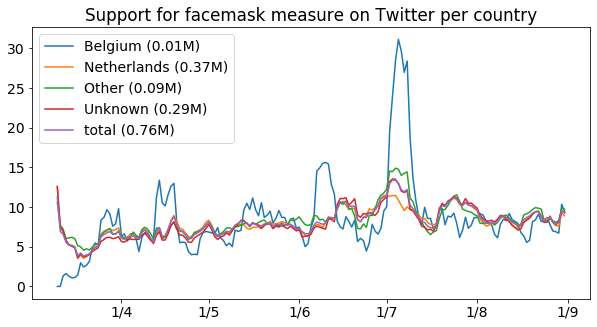

In [28]:
TARGETLOCATIONS = [BELGIUM,NETHERLANDS,OTHER,UNKNOWN]
STARTDATE = 20200310

def readStanceDataFromFiles():
    results = {}
    for month in "202003 202004 202005 202006 202007 202008".split():
        try:
            resultsDf = pd.read_csv(f"results-{TOPIC}-{month}.csv",index_col=DATE)
            results = {**results,**(resultsDf.T.to_dict())}
        except: print(f"skipping {month}")
    return(results)

def convertStringsToDictionaries(results):
    for date in sorted(results.keys()):
        toBeDeleted = []
        for nielsen in results[date].keys():
            try:
                results[date][nielsen] = ast.literal_eval(results[date][nielsen])
            except:
                toBeDeleted.append((date,nielsen))
        for date,nielsen in toBeDeleted: del(results[date][nielsen])
    return(results)

def combineStanceData(results):
    totals = {location:0 for location in TARGETLOCATIONS+[TOTAL]}
    for date in sorted(results.keys()):
        for nielsen in sorted(results[date].keys()):
            if nielsen != TOTAL:
                if not SUPPORTS in results[date][nielsen]: results[date][nielsen][SUPPORTS] = 0.0
                if not REJECTS in results[date][nielsen]: results[date][nielsen][REJECTS] = 0.0
                if results[date][nielsen][SUPPORTS] + results[date][nielsen][REJECTS] > 0:
                    if not TOTAL in results[date]: results[date][TOTAL] = {SUPPORTS:0,REJECTS:0,TOTAL:0}
                    results[date][TOTAL][SUPPORTS] += results[date][nielsen][SUPPORTS]*results[date][nielsen][TOTAL]/100
                    results[date][TOTAL][REJECTS] += results[date][nielsen][REJECTS]*results[date][nielsen][TOTAL]/100
                    results[date][TOTAL][TOTAL] += results[date][nielsen][TOTAL]
    for date in sorted(results.keys()):
        if TOTAL in results[date]:
            results[date][TOTAL][SUPPORTS] /= 0.01*results[date][TOTAL][TOTAL]
            results[date][TOTAL][REJECTS] /= 0.01*results[date][TOTAL][TOTAL]
            totals[TOTAL] += results[date][TOTAL][TOTAL]
    return(results,totals)

# get data for other graphs
def includeRegionData(results,totals):
    for date in sorted(results.keys()):
        for country in TARGETLOCATIONS:
            if not country in results[date]: results[date][country] = {}
            if TOTAL in results[date][country]: totals[country] += results[date][country][TOTAL]
            for nielsen in results[date].keys():
                if nielsen != country and re.search(country,nielsen):
                    if TOTAL in results[date][nielsen]: totals[country] += results[date][nielsen][TOTAL]
                    for label in results[date][nielsen]:
                        if label != TOTAL:
                            if not label in results[date][country]: results[date][country][label] = 0
                            if not TOTAL in results[date][country]: results[date][country][TOTAL] = 0
                            results[date][country][label] = (results[date][country][label]*results[date][country][TOTAL]+\
                                                             results[date][nielsen][label]*results[date][nielsen][TOTAL])/\
                                                            (results[date][country][TOTAL]+results[date][nielsen][TOTAL])
                            results[date][country][TOTAL] += results[date][nielsen][TOTAL]
    return(results,totals)

def makePlotDataCountries(results):
    x = {}
    y = {}
    for date in sorted(results.keys()):
        if date >= STARTDATE:
            for nielsen in sorted(results[date].keys()):
                if not re.search(NIELSEN,nielsen.lower()):
                    xNielsen = nielsen
                    if nielsen == UNKNOWN: xNielsen = UNKNOWNLABEL
                    if not SUPPORTS in results[date][nielsen]: results[date][nielsen][SUPPORTS] = 0.0
                    if not REJECTS in results[date][nielsen]: results[date][nielsen][REJECTS] = 0.0
                    if results[date][nielsen][SUPPORTS] + results[date][nielsen][REJECTS] > 0:
                        if not xNielsen in x:
                            x[xNielsen] = []
                            y[xNielsen] = []
                        x[xNielsen].append(datetime.datetime.strptime(str(date),DATEFORMAT))
                        y[xNielsen].append(results[date][nielsen][SUPPORTS])
    return(x,y)

def visualizeCountries(x,y,totals):
    font = {"size":14}
    matplotlib.rc("font",**font)
    fig,ax = plt.subplots(figsize=(10,5))
    for nielsen in sorted(x.keys()):
        if nielsen == UNKNOWNLABEL: label = "-"
        else: label = nielsen
        plt.plot_date(x[nielsen],movingAverage(y[nielsen],WEEKLENGTH),fmt="-",label=f"{nielsen} ({round(totals[label]/1000000,2)}M)")
    plt.legend()
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%-d/%-m"))
    plt.title("Support for facemask measure on Twitter per country")
    plt.savefig(PLOTFILENAMECOUNTRIES)
    plt.show()

results = readStanceDataFromFiles()
results = convertStringsToDictionaries(results)
results,totals = combineStanceData(results)
results,totals = includeRegionData(results,totals)
x,y = makePlotDataCountries(results)
visualizeCountries(x,y,totals)

## Visualization (regions)

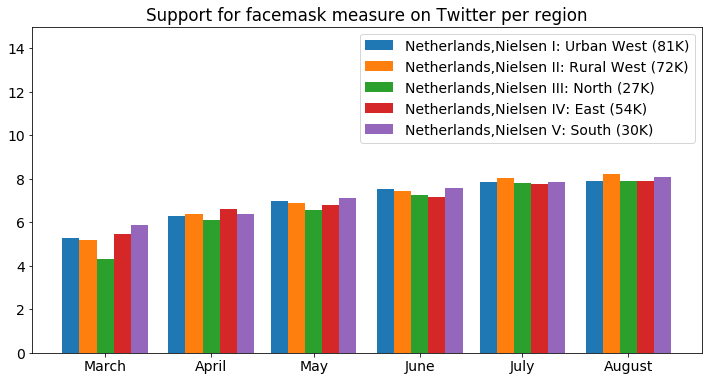

In [29]:
PLOTFILENAMEREGIONS = f"stance-{TOPIC}-geo-region.png"
BARWIDTH = 5
ALIAS = {"Netherlands,Nielsen I":"Urban West",
         "Netherlands,Nielsen II":"Rural West",
         "Netherlands,Nielsen III":"North",
         "Netherlands,Nielsen IV":"East",
         "Netherlands,Nielsen V":"South"}

def makePlotDataRegions(results):
    x = {}
    for date in sorted(results.keys()):
        if date >= STARTDATE:
            month = str(date)[0:6]+"01"
            for nielsen in sorted(results[date].keys()):
                if re.search(NETHERLANDS.lower(),nielsen.lower()) and re.search(NIELSEN,nielsen.lower()):
                    xNielsen = nielsen
                    if nielsen == UNKNOWN: xNielsen = UNKNOWNLABEL
                    if not SUPPORTS in results[date][nielsen]: results[date][nielsen][SUPPORTS] = 0.0
                    if not REJECTS in results[date][nielsen]: results[date][nielsen][REJECTS] = 0.0
                    if results[date][nielsen][SUPPORTS] + results[date][nielsen][REJECTS] > 0:
                        if not xNielsen in x: x[xNielsen] = {}
                        datetimeMonth = datetime.datetime.strptime(str(month),DATEFORMAT)
                        if not datetimeMonth in x[xNielsen]: x[xNielsen][datetimeMonth] = {SUPPORTS:0,TOTAL:0}
                        x[xNielsen][datetimeMonth][SUPPORTS] += results[date][nielsen][SUPPORTS]*results[date][nielsen][TOTAL]
                        x[xNielsen][datetimeMonth][TOTAL] += results[date][nielsen][TOTAL]
    return(x)

def visualizeRegions(x):
    font = {"size":14}
    matplotlib.rc("font",**font)
    fig,ax = plt.subplots(figsize=(12,6))
    counter = -2*BARWIDTH
    for nielsen in sorted(x.keys()):
        if nielsen == UNKNOWNLABEL: label = "-"
        else: label = nielsen
        total = sum([x[nielsen][date][TOTAL] for date in x[nielsen]])
        ax.bar([d+datetime.timedelta(days=counter) for d in sorted(x[nielsen].keys())],
                movingAverage([x[nielsen][d][SUPPORTS]/x[nielsen][d][TOTAL] for d in sorted(x[nielsen].keys())],WEEKLENGTH),
                width=BARWIDTH,label=f"{nielsen}: {ALIAS[nielsen]} ({round(total/1000)}K)")
        counter += BARWIDTH
    plt.ylim(0,15)
    ax.xaxis_date()
    plt.legend(framealpha=0.8)
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%B"))
    plt.title("Support for facemask measure on Twitter per region")
    plt.savefig(PLOTFILENAMEREGIONS)
    plt.show()

x = makePlotDataRegions(results)
visualizeRegions(x)